In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
animal_df = pd.read_csv('/work/Animal Shelter Data/species_combined.csv')

census_df = pd.read_csv('/work/Census ACS Data/census_data.csv')

economics_df = pd.read_csv('/work/nc_county_census_total.csv')

# Display basic information
print(census_df.head())  # Preview first few rows
print(economics_df.head())  # Preview first few rows
# Check missing values after preprocessing

   Unnamed: 0            county  population  median_income  owner_occupied  \
0           0   Alamance County    171779.0        60866.0         44487.0   
1           1  Alexander County     36505.0        62764.0         11180.0   
2           2  Alleghany County     10989.0        42115.0          3975.0   
3           3      Anson County     22200.0        42000.0          5572.0   
4           4       Ashe County     26759.0        49176.0          9431.0   

   renter_occupied  homeownership_rate  rental_rate  
0          22883.0            0.660338         34.0  
1           2581.0            0.812441         18.8  
2            962.0            0.805145         19.5  
3           2694.0            0.674087         32.6  
4           2392.0            0.797682         20.2  
                        county_name  county  total_population  poverty_rate  \
0   Alamance County, North Carolina       1            171779          14.2   
1  Alexander County, North Carolina       3      

In [2]:
economics_df.drop(columns=['county'], inplace=True)
census_df.drop(columns=["Unnamed: 0", 'population', 'median_income'], inplace=True)

In [3]:
# Rename the column
economics_df.rename(columns={'county_name': 'county'}, inplace=True)

# Remove "County, North Carolina" and convert to uppercase
economics_df['county'] = economics_df['county'].str.replace(r'\s*County, North Carolina', '', regex=True).str.upper()


census_df["county"] = census_df["county"].str.replace("County", "", case=False).str.strip().str.upper()
census_df["county"] = census_df["county"].str.replace("County", "", case=False).str.strip().str.upper()

In [4]:
df = animal_df.merge(census_df, on="county", how="inner")
df = df.merge(economics_df, on="county", how="inner")

In [5]:
print(df)

       county  intake  adjusted_intake  adopted_out  returned_to_owner  \
0    ALAMANCE  6177.0           5735.0       5273.0              442.0   
1   ALEXANDER   555.0            455.0        265.0              100.0   
2       ANSON   869.0            825.0        785.0               44.0   
3        ASHE  1044.0            927.0        898.0              117.0   
4    BEAUFORT  1653.0           1554.0       1084.0               99.0   
..        ...     ...              ...          ...                ...   
59     WARREN  1051.0            979.0        763.0               72.0   
60      WAYNE  3184.0           2940.0       1383.0              244.0   
61     WILKES  4800.0           4580.0       1764.0              220.0   
62     WILSON  2072.0           1776.0        919.0              296.0   
63     YADKIN   896.0            825.0        568.0               71.0   

    euthanized  adoption_rate  euthanasia_rate  owner_occupied  \
0        344.0      91.944202         5.99825

In [6]:
df.to_csv('fully_combined.csv', index=False)

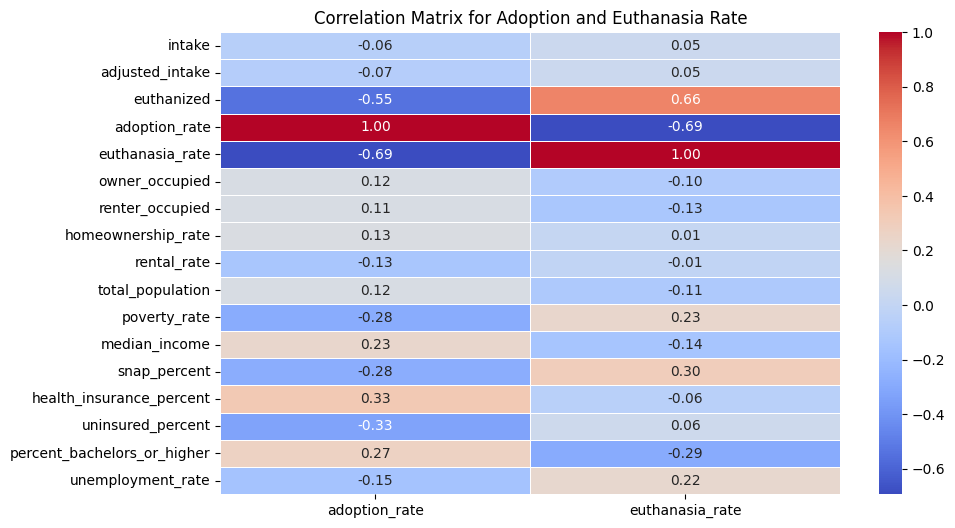

In [7]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])  # Keeps only numeric features

# Drop unwanted columns
numeric_df = numeric_df.drop(columns=['adopted_out', 'returned_to_owner'], errors='ignore')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Extract correlations with adoption_rate and euthanasia_rate
target_corr = corr_matrix[['adoption_rate', 'euthanasia_rate']]

# Visualize correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Adoption and Euthanasia Rate')
plt.show()

In [8]:
# Top 10 counties with highest adoption rates
top_adoption = df[['county', 'adoption_rate']].sort_values(by='adoption_rate', ascending=False).head(10)
print(top_adoption)

# Top 10 counties with highest euthanasia rates
top_euthanasia = df[['county', 'euthanasia_rate']].sort_values(by='euthanasia_rate', ascending=False).head(10)
print(top_euthanasia)

          county  adoption_rate
34       LINCOLN      96.930946
3           ASHE      96.871629
2          ANSON      95.151515
0       ALAMANCE      91.944202
44        ORANGE      90.416846
30       HAYWOOD      89.561753
12       CASWELL      89.536266
58          WAKE      86.301370
26        GASTON      85.656042
55  TRANSYLVANIA      85.432473
      county  euthanasia_rate
54     SURRY        78.461538
16  COLUMBUS        78.317308
32  JOHNSTON        74.309921
37    MARTIN        70.400000
61    WILKES        61.200873
45    PERSON        59.421423
48   ROBESON        55.926048
41      NASH        55.784469
20  DAVIDSON        55.036938
47  RANDOLPH        54.560421


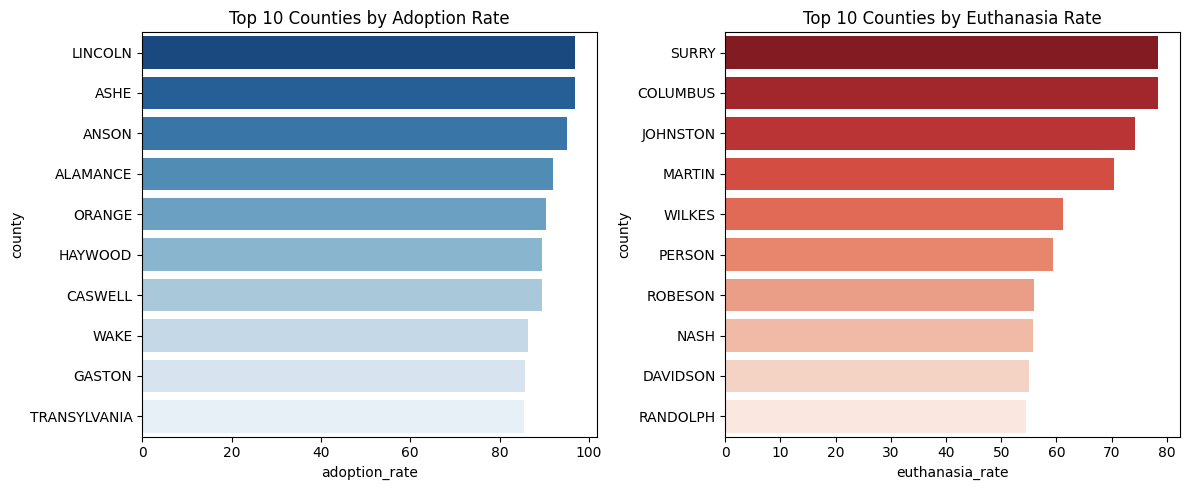

In [9]:
plt.figure(figsize=(12, 5))

# Adoption Rate Bar Plot
plt.subplot(1, 2, 1)
sns.barplot(data=top_adoption, x='adoption_rate', y='county', hue='county', palette='Blues_r', legend=False)
plt.title('Top 10 Counties by Adoption Rate')

# Euthanasia Rate Bar Plot
plt.subplot(1, 2, 2)
sns.barplot(data=top_euthanasia, x='euthanasia_rate', y='county', hue='county', palette='Reds_r', legend=False)
plt.title('Top 10 Counties by Euthanasia Rate')

plt.tight_layout()
plt.show()


### Linear Regression

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Select relevant features and target variables
features = ['median_income', 'poverty_rate', 'snap_percent', 'homeownership_rate', 
            'health_insurance_percent', 'uninsured_percent', 'renter_occupied', 'owner_occupied','unemployment_rate'
            ,'percent_bachelors_or_higher']
target_adoption = 'adoption_rate'

# Split data into training and testing sets (80/20)
X = df[features]
y_adoption = df[target_adoption]

X_train, X_test, y_train_adopt, y_test_adopt = train_test_split(X, y_adoption, test_size=0.2, random_state=42)

#Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)        # Only transform test data

# Train Linear Regression models
model_adopt = LinearRegression()

model_adopt.fit(X_train, y_train_adopt)

# Make predictions
y_pred_adopt = model_adopt.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Model Performance:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

evaluate_model(y_test_adopt, y_pred_adopt, "Adoption Rate")



Adoption Rate Model Performance:
R² Score: -0.1916
MAE: 18.32
RMSE: 24.19


In [11]:
# Select relevant features and target variables
features = ['median_income', 'poverty_rate', 'snap_percent', 'homeownership_rate', 
            'health_insurance_percent', 'uninsured_percent', 'renter_occupied', 'owner_occupied','unemployment_rate'
            ,'percent_bachelors_or_higher']

target_euthanasia = 'euthanasia_rate'

# Split data into training and testing sets (80/20)
X = df[features]
y_euthanasia = df[target_euthanasia]

X_train, X_test, y_train_euth, y_test_euth = train_test_split(X, y_euthanasia, test_size=0.2, random_state=42)

#Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)        # Only transform test data

# Train Linear Regression models
model_euth = LinearRegression()

model_euth.fit(X_train_scaled, y_train_euth)

# Make predictions
y_pred_euth = model_euth.predict(X_test_scaled)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Model Performance:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

    print(df['euthanasia_rate'].describe())
    print("Intercept:", model_euth.intercept_)
    print("Coefficients:", model_euth.coef_)


evaluate_model(y_test_euth, y_pred_euth, "Euthanasia Rate")


Euthanasia Rate Model Performance:
R² Score: -0.5239
MAE: 19.39
RMSE: 27.29
count    64.000000
mean     31.213192
std      19.940804
min       0.606061
25%      13.895637
50%      27.761203
75%      45.599067
max      78.461538
Name: euthanasia_rate, dtype: float64
Intercept: 31.317095686690383
Coefficients: [ 12.69566721   9.70318061   2.86517471  -4.51227999   0.75926409
  -0.75926409 -29.31949078  29.44396156  -0.22968924  -8.32231415]


Linear Regression Model: Poor performance

In [12]:
from sklearn.model_selection import train_test_split

# Define feature columns (excluding non-numeric and unwanted variables)
features = [
    "owner_occupied", "renter_occupied", "homeownership_rate", "rental_rate",
    "total_population","poverty_rate", "median_income", "snap_percent", "health_insurance_percent",
    "uninsured_percent"
]

target_adoption = "adoption_rate"
target_euthanasia = "euthanasia_rate"

# Drop missing values for selected features and targets
df_clean = df.dropna(subset=features + [target_adoption, target_euthanasia])

# Define X and y
X = df_clean[features]
y_adoption = df_clean[target_adoption]
y_euthanasia = df_clean[target_euthanasia]

# Split into training and test sets (80/20 split)
X_train, X_test, y_train_adoption, y_test_adoption = train_test_split(
    X, y_adoption, test_size=0.2, random_state=42
)
X_train, X_test, y_train_euthanasia, y_test_euthanasia = train_test_split(
    X, y_euthanasia, test_size=0.2, random_state=42
)


### Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Model for Adoption Rate
rf_adoption = RandomForestRegressor(random_state=42)
rf_adoption.fit(X_train, y_train_adoption)

# Predictions
y_pred_adoption = rf_adoption.predict(X_test)

# Evaluate performance
r2_adoption = r2_score(y_test_adoption, y_pred_adoption)
mae_adoption = mean_absolute_error(y_test_adoption, y_pred_adoption)
rmse_adoption = mean_squared_error(y_test_adoption, y_pred_adoption, squared=False)

# Print performance metrics for adoption rate
print(f"Adoption Rate Model Performance (Random Forest):")
print(f"R² Score: {r2_adoption:.4f}")
print(f"MAE: {mae_adoption:.4f}")
print(f"RMSE: {rmse_adoption:.4f}")

# Random Forest Model for Euthanasia Rate
rf_euthanasia = RandomForestRegressor(random_state=42)
rf_euthanasia.fit(X_train, y_train_euthanasia)

# Predictions
y_pred_euthanasia = rf_euthanasia.predict(X_test)

# Evaluate performance
r2_euthanasia = r2_score(y_test_euthanasia, y_pred_euthanasia)
mae_euthanasia = mean_absolute_error(y_test_euthanasia, y_pred_euthanasia)
rmse_euthanasia = mean_squared_error(y_test_euthanasia, y_pred_euthanasia, squared=False)

# Print performance metrics for euthanasia rate
print(f"\nEuthanasia Rate Model Performance (Random Forest):")
print(f"R² Score: {r2_euthanasia:.4f}")
print(f"MAE: {mae_euthanasia:.4f}")
print(f"RMSE: {rmse_euthanasia:.4f}")

Adoption Rate Model Performance (Random Forest):
R² Score: 0.2674
MAE: 16.4232
RMSE: 18.9645

Euthanasia Rate Model Performance (Random Forest):
R² Score: -0.0501
MAE: 18.6496
RMSE: 22.6544


Random Forest Model: Moderate performance

Both models show low explanatory power (R²), meaning there are likely other factors not captured in the model that influence the adoption and euthanasia rates.

In [14]:
import pandas as pd

# Assuming your DataFrame is named df
mecklenburg_adoption_rate = df.loc[df['county'].str.upper() == 'MECKLENBURG', 'adoption_rate'].values[0]
print(f"Mecklenburg County Adoption Rate: {mecklenburg_adoption_rate}")


Mecklenburg County Adoption Rate: 63.10446166176863


In [15]:
import pandas as pd

# Choose relevant columns
cols_to_correlate = [
    'intake',
    'adopted_out',
    'adoption_rate',
    'euthanasia_rate',
    'homeownership_rate',
    'total_population',
    'poverty_rate',
    'median_income',
    'snap_percent',
    'health_insurance_percent',
    'uninsured_percent',
    'percent_bachelors_or_higher',
    'unemployment_rate'    
]

# Calculate the correlation matrix
correlation_matrix = df[cols_to_correlate].corr()
print(correlation_matrix)


                               intake  adopted_out  adoption_rate  \
intake                       1.000000     0.844546      -0.063701   
adopted_out                  0.844546     1.000000       0.378812   
adoption_rate               -0.063701     0.378812       1.000000   
euthanasia_rate              0.045883    -0.303301      -0.693487   
homeownership_rate          -0.347379    -0.330777       0.132251   
total_population             0.731402     0.734343       0.118934   
poverty_rate                -0.214396    -0.322225      -0.284556   
median_income                0.368171     0.444889       0.229158   
snap_percent                -0.194634    -0.304418      -0.280751   
health_insurance_percent     0.106939     0.270808       0.333346   
uninsured_percent           -0.106939    -0.270808      -0.333346   
percent_bachelors_or_higher  0.411280     0.510176       0.266004   
unemployment_rate           -0.118708    -0.142048      -0.152970   

                             euth

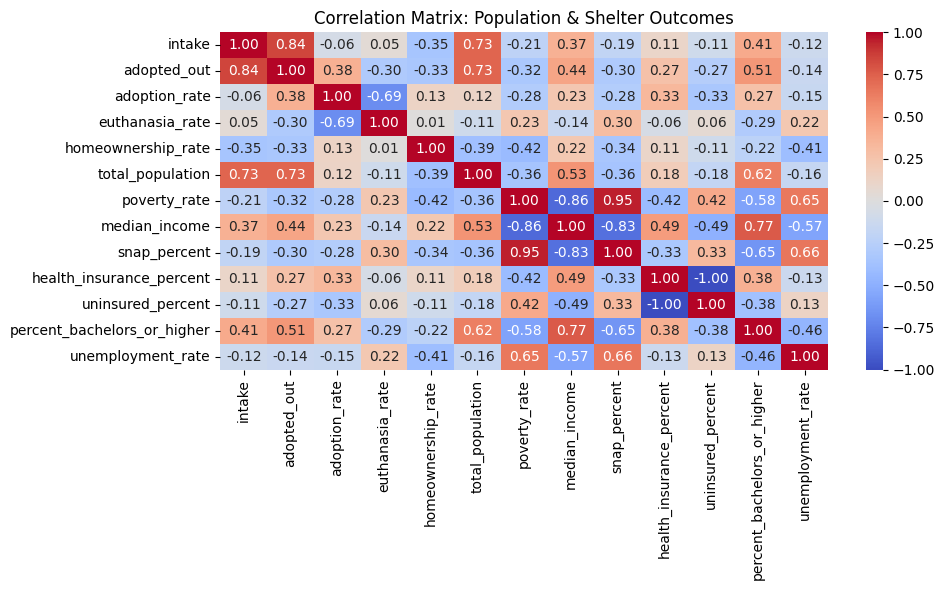

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Population & Shelter Outcomes')
plt.tight_layout()
plt.show()


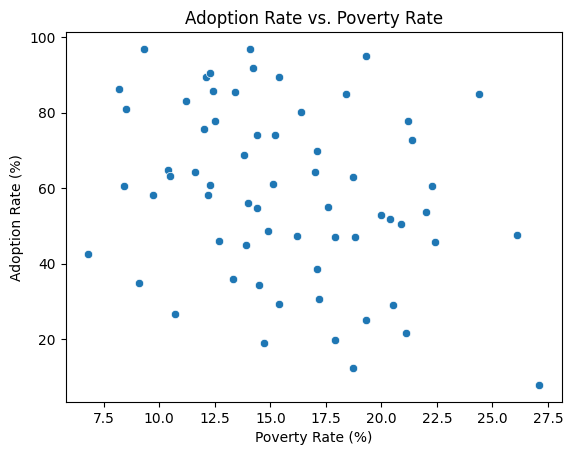

In [17]:
sns.scatterplot(data=df, x='poverty_rate', y='adoption_rate')
plt.title('Adoption Rate vs. Poverty Rate')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Adoption Rate (%)')
plt.show()
